# Info
On the files contained in this repo
```bash
> # wc -l *.py
  163 02_pyspark/analysis.py      #< functionality of this notebook
   77 02_pyspark/main2.py         #< Spark program 
   68 02_pyspark/operatorImpl.py  #     - Operator used for spark
   97 02_pyspark/parser.py        #     - Parser
   95 02_pyspark/streamListImpl.py#     - Listener
   42 xx_migrate/generate_cluster_data.py     # irrelevant
   66 xx_migrate/streaming_k_means_example.py # 
  771 total
> # ipynb files
drwxr-xr-x 1 19:00 01_exploreData # contains scripts for explroing
                                  # different datasets
-rw-r--r-- 1 18:44 01_exploreData/unusedExploration/Crimes.ipynb
-rw-r--r-- 1 18:56 01_exploreData/unusedExploration/Phone.ipynb
-rw-r--r-- 1 18:44 01_exploreData/unusedExploration/Power.ipynb
-rw-r--r-- 1 14 12:32 01_exploreData/Sports exploration.ipynb
-rw-r--r-- 1 13:09 02_pyspark/AnalyzerTobemerged.ipynb
```

In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

from matplotlib.widgets import Slider
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D


In [3]:
amountBatches = 60
amountClusters = 3
dim = 45

<IPython.core.display.Javascript object>


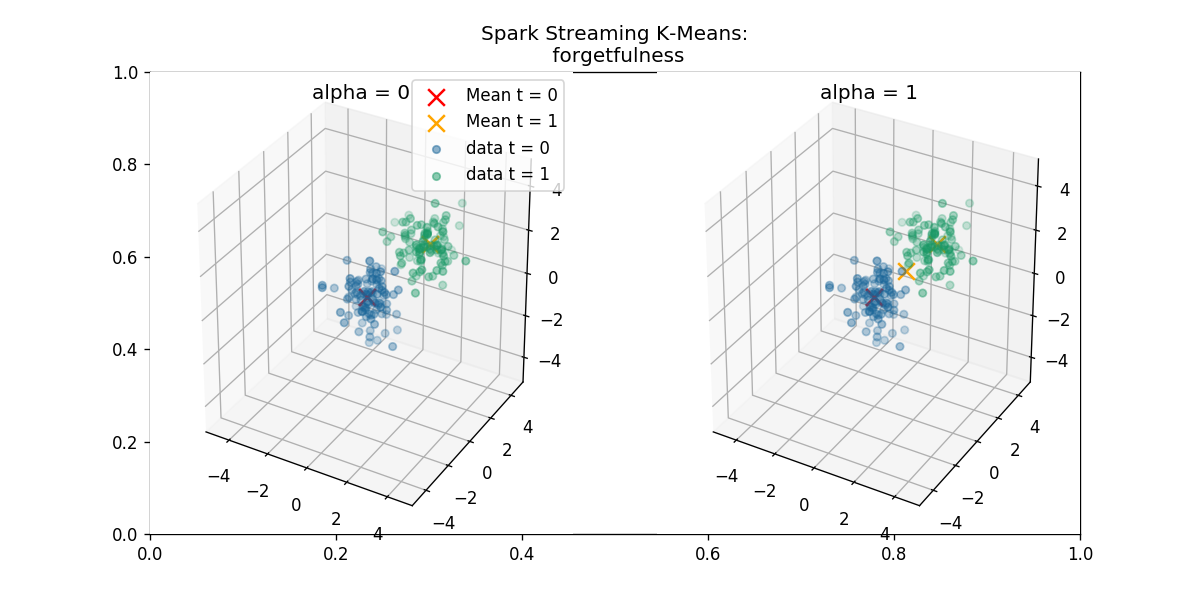

In [4]:
def makeSamplePlot():
    # sample plot
    samples_in_cluster = 100
    mean = np.array([-0, -0, -0])
    mean2 = mean + 2
    c0 = np.random.multivariate_normal(
        mean, np.identity(3)*.5, samples_in_cluster)
    c1 = np.random.multivariate_normal(
        mean2, np.identity(3)*.5, samples_in_cluster)
    fig = plt.figure(figsize=(10,5))
    plt.title("Spark Streaming K-Means:\n forgetfulness")
    ax = fig.add_subplot(121, projection='3d')
    ax.set_title("alpha = 0")
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))
    ax.set_zlim((-5, 5))
    ax.scatter(mean[0], mean[1], mean[2], marker="x", s=100, c="red", label="Mean t = 0")
    ax.scatter(mean2[0], mean2[1], mean2[2], marker="x", s=100, c="orange", label="Mean t = 1")
    ax.scatter(c0[:,0], c0[:,1], c0[:,2], c=(.1, .4, .6, .5), label="data t = 0")
    ax.scatter(c1[:,0], c1[:,1], c1[:,2], c=(.1, .6, .4, .5), label="data t = 1")
    ax.scatter(mean[0], mean[1], mean[2], marker="x", s=100, c="red")
    ax.scatter(mean2[0], mean2[1], mean2[2], marker="x", s=100, c="orange")

    plt.legend()


    ax = fig.add_subplot(122, projection='3d')
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))
    ax.set_zlim((-5, 5))
    ax.set_title("alpha = 1")
    ax.scatter(mean[0], mean[1], mean[2], marker="x", s=100, c="red", label="Mean t = 0")
    ax.scatter(mean2[0], mean2[1], mean2[2], marker="x", s=100, c="orange", label="Mean t = 1")
    ax.scatter(c0[:,0], c0[:,1], c0[:,2], c=(.1, .4, .6, .5), label="data t = 0")
    ax.scatter(c1[:,0], c1[:,1], c1[:,2], c=(.1, .6, .4, .5), label="data t = 1")
    ax.scatter(mean[0], mean[1], mean[2], marker="x", s=100, c="red")
    ax.scatter((mean2[0] + mean[0]) / 2, (mean2[0] + mean[0]) / 2, (mean2[0] + mean[0]) / 2, marker="x", s=100, c="orange")

makeSamplePlot()

In [6]:
def loadCenters(amountClusters):

    # fetch the batch
    batch = np.array(np.loadtxt("../01_exploreData/out/check/centers.csv", delimiter=','))
    val = batch[0:60*amountClusters]
    batch = batch[:amountClusters*60,:] #< discard batchest that are non-existent. 
    batch_times = batch.reshape([int(batch.shape[0]/amountClusters), amountClusters, batch.shape[1]])

    # u never know unless u think! or insert assertions!
    if 0:
        assert((val[0] == batch_times[0,0]).all())
        assert((val[1] == batch_times[0,1]).all())
        assert((val[2] == batch_times[0,2]).all())
        assert((val[3] == batch_times[1,0]).all())

    return batch_times, batch

def loadCenter(amountClusters, path="../01_exploreData/out/check/centers.csv" ):
    
    print(path)
    

    # fetch the batch
    batch = np.array(np.loadtxt(path, delimiter=','))
   
    val = batch[0:60*amountClusters]
    print("hier", batch.shape, val.shape, "amountclusters", amountClusters)
    
    batch = batch[:amountClusters*60,:] #< discard batchest that are non-existent. 
    batch = batch.reshape([int(batch.shape[0]/amountClusters), amountClusters, batch.shape[1]])

    return batch

In [7]:
def loadFeatures(path="../01_exploreData/out/check/testRaw.csv"):
    # fetch the batch
    batch = np.array(np.loadtxt(path, delimiter=','))
    line_per_batch = int(batch.shape[0] / amountBatches)
    print(line_per_batch)
    print(batch.shape)
    batch_times = batch.reshape([amountBatches, line_per_batch, batch.shape[1]])
    return batch_times, batch

In [8]:
def getObjective(t, features, labels, centers):
    """
    :features:   The feature vector of dimensionality [times x linesPerTime x Dim=45]
    :labels:   The feature vector of dimensionality   [times x linesPerTime]
    """
    
    features = features[t]
    labels = labels[t]
    centers = centers[t]
    
    means = [centers[l] for l in labels.astype(int)]
    obj = np.linalg.norm(means - features) / labels.shape[0]
    return obj

def getWorst(t, features, labels, centers):
    """
    :features:   The feature vector of dimensionality [times x linesPerTime x Dim=45]
    :labels:   The feature vector of dimensionality   [times x linesPerTime]
    """
    
    features = features[t]
    labels = labels[t]
    centers = centers[t]
    
    means = np.mean(features)
    obj = np.linalg.norm(means - features) / labels.shape[0]
    return obj

In [9]:
centers, centers_flat = loadCenters(amountClusters)
print(centers_flat.shape)
print(centers.shape)

(180, 45)
(60, 3, 45)


In [10]:
testFeatures, testFeatures_flat = loadFeatures()
print(testFeatures_flat.shape)
print(testFeatures.shape)

628
(37680, 45)
(37680, 45)
(60, 628, 45)


In [12]:
trainFeatures, trainFeatures_flat = loadFeatures("../01_exploreData/out/check/trainRaw.csv")
print(trainFeatures_flat.shape)
print(trainFeatures.shape)

18220
(1093200, 45)
(1093200, 45)
(60, 18220, 45)


In [13]:
testLabels, testLabels_flat = loadFeatures("../01_exploreData/out/check/testLabels.csv")
testLabels = testLabels[:,:,1]
print(testLabels_flat.shape)
print(testLabels.shape)

628
(37680, 2)
(37680, 2)
(60, 628)


<IPython.core.display.Javascript object>


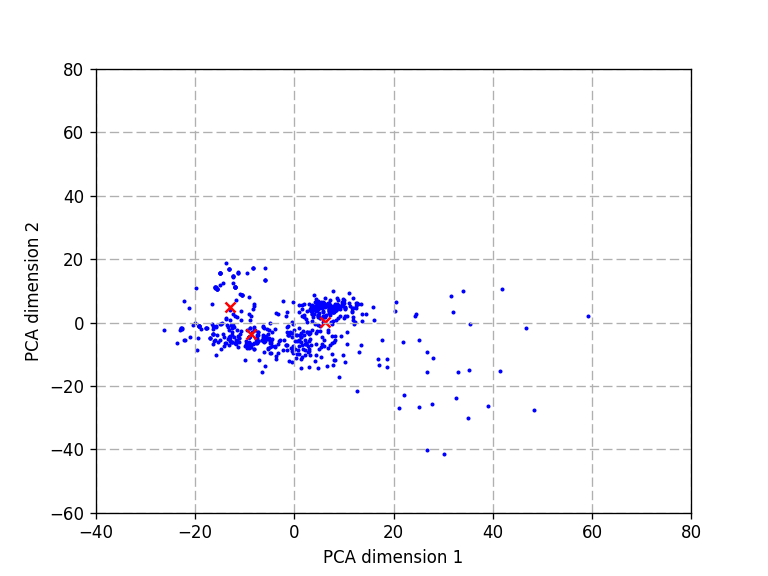

[[ -8.74832724  -3.69924767]
 [-12.96962168   4.85837681]
 [  6.18233251   0.26339751]]


<IPython.core.display.Javascript object>


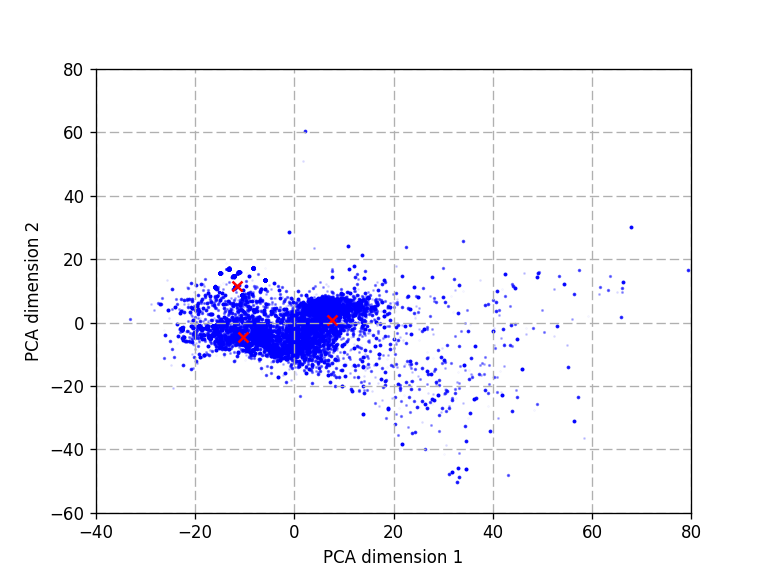

[[-10.34139595  -4.55877607]
 [-11.63467037  11.65675277]
 [  7.57729306   0.72029774]]


<IPython.core.display.Javascript object>


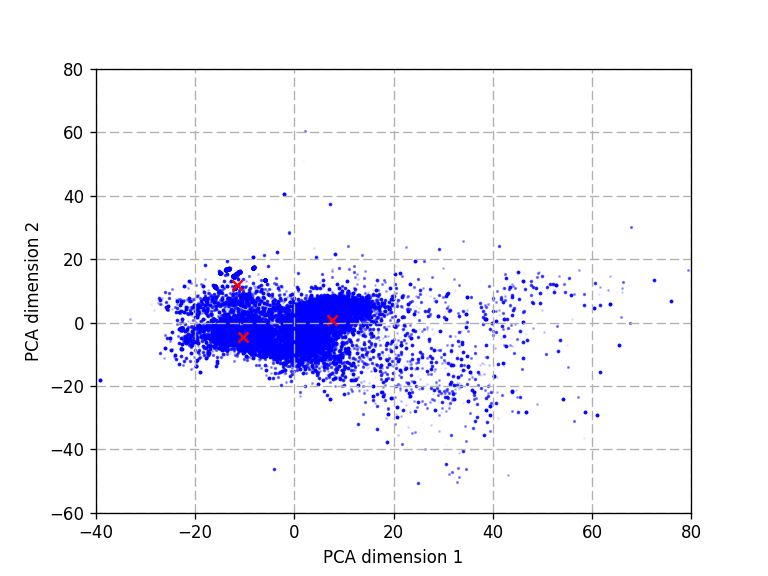

[[-10.36467012  -4.49157289]
 [-11.63674364  11.70436724]
 [  7.52801391   0.70627349]]


<IPython.core.display.Javascript object>


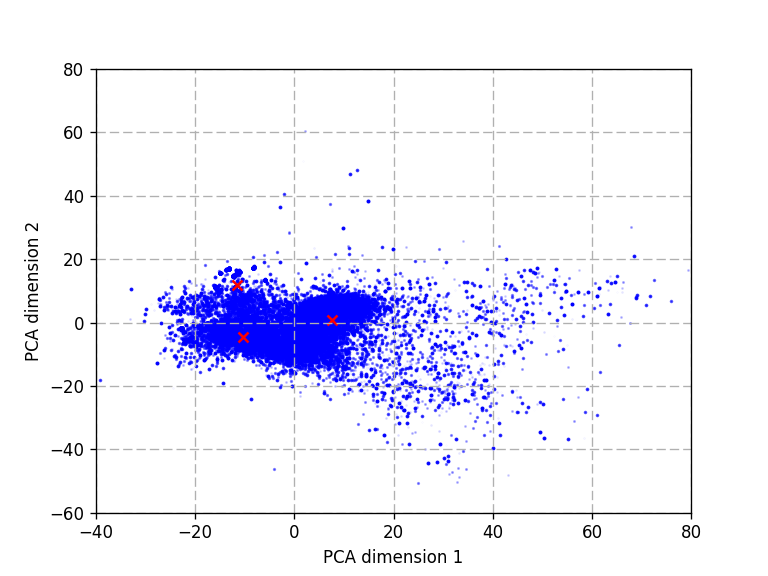

[[-10.34371307  -4.4624789 ]
 [-11.63224032  11.82207194]
 [  7.6229997    0.79238644]]


<IPython.core.display.Javascript object>


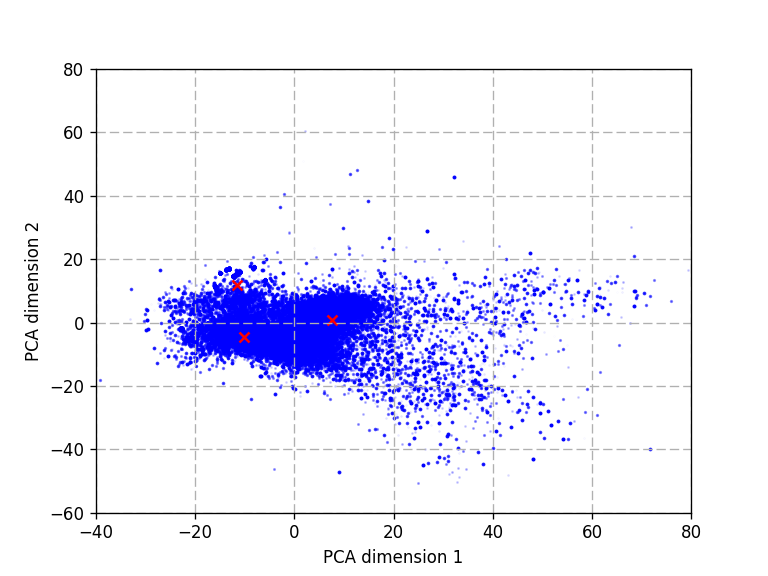

[[-10.17503549  -4.60258577]
 [-11.62061133  11.87724348]
 [  7.54767012   0.68729684]]


In [14]:
def plot_reduced_dim_test(dim, batchnr):
    pca = PCA(n_components=dim)
    testFeatures_pca = pca.fit(testFeatures_flat)
    
    testFeatures_0_dim2 = testFeatures_pca.transform(testFeatures[batchnr])
    centers_0_dim2 = testFeatures_pca.transform(centers[batchnr])
    #print(testFeatures_0_dim2.shape)
    #print(centers_0_dim2.shape)

    plt.figure()
    plt.scatter(testFeatures_0_dim2[:,0], testFeatures_0_dim2[:,1], s=.2)
    plt.scatter(centers_0_dim2[:,0], centers_0_dim2[:,1], marker='x')

def merge_features(inputdata, batchnr_start, batchnr_end):
    if(batchnr_end > batchnr_start):
        features = np.vstack((inputdata[batchnr_start], inputdata[batchnr_start+1]))
        if(batchnr_start+2 == batchnr_end):
            features = np.vstack((features, inputdata[batchnr_start+2]))
        if(batchnr_start+2 < batchnr_end):
            for i in range(batchnr_start+2, batchnr_end+1):
                features = np.vstack((features, inputdata[i]))
    elif(batchnr_start == batchnr_end):
        features = inputdata[batchnr_start]
    else:
        print("batch_end should be greater than batch_start!")
    #print(features.shape)
    return features
    

def plot_reduced_dim_cumulated_test(dim, batchnr_start, batchnr_end, name):
    pca = PCA(n_components=dim)
    testFeatures_pca = pca.fit(testFeatures_flat)
    
    plt.figure()
    plt.grid(True, linestyle='--')
    plt.xlim((-40, 80))
    plt.ylim((-60, 80))
    plt.xlabel('PCA dimension 1')
    plt.ylabel('PCA dimension 2')
    for i in range(batchnr_start, batchnr_end):
        features_dim2 = testFeatures_pca.transform(testFeatures[i])
        #print(features_dim2.shape)
        transparence = float((i+1.)/batchnr_end)
        plt.scatter(features_dim2[:,0], features_dim2[:,1], s=transparence*2, color=(0,0,1,transparence))
        #print((i+1.)*batchnr_end/10., batchnr_end, 10, i)

    centers_dim2 = testFeatures_pca.transform(centers[batchnr_end])
    print(centers_dim2)
    plt.scatter(centers_dim2[:,0], centers_dim2[:,1], marker='x', color = 'r')
    plt.savefig(name)
    
    """
    for i in range(batchnr_start, batchnr_end):

        features = merge_features(testFeatures, 0, i+1)
        features_dim2 = testFeatures_pca.transform(features)
        centers_dim2 = testFeatures_pca.transform(centers[i+1])

        plt.figure()
        plt.scatter(features_dim2[:,0], features_dim2[:,1], s=.2)
        plt.scatter(centers_dim2[:,0], centers_dim2[:,1], marker='x')
    """

plot_reduced_dim_cumulated_test(2, 0, 1, "../00_documentation/1")
plot_reduced_dim_cumulated_test(2, 0, 15, "../00_documentation/15")
plot_reduced_dim_cumulated_test(2, 0, 30, "../00_documentation/30")
plot_reduced_dim_cumulated_test(2, 0, 45, "../00_documentation/45")
plot_reduced_dim_cumulated_test(2, 0, 59, "../00_documentation/60")


<IPython.core.display.Javascript object>


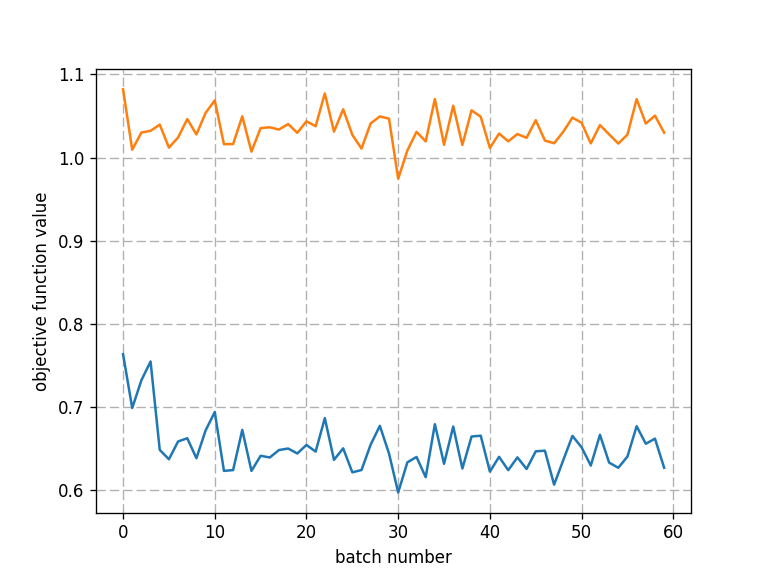

[0.76346423390392415, 0.69869624158465893, 0.73209194432764679, 0.75464427969410786, 0.64833594466544231, 0.63707151008788365, 0.65844895397287462, 0.6623413158541902, 0.63833478661176823, 0.67170467040438586, 0.69386247071584128, 0.62309723360733349, 0.62401959950680252, 0.67235498990279208, 0.62305273581007914, 0.64122981665667955, 0.63919833944479798, 0.64814374450602696, 0.64998068761344174, 0.64404091547175413, 0.65429641806440708, 0.64630119628810268, 0.68653280249498616, 0.63633867149997969, 0.65019724388395972, 0.62134367471604801, 0.6241234426135811, 0.65470241713357902, 0.67725456430309061, 0.64397693029019465, 0.59710380861876089, 0.63335436349505503, 0.63982468969018169, 0.61550511796588092, 0.67921695578994623, 0.63159846639748307, 0.67640421624439606, 0.62594855102974589, 0.66443455388928052, 0.66540773692127386, 0.62217903839743838, 0.63997562216265214, 0.62396177749726478, 0.63931772017907307, 0.62538560564574219, 0.6466234843380938, 0.64737047047903062, 0.6065009049158

In [16]:
# Simple plot that shows the behavior of the objective 
# function over time.
j = [ getObjective(t, testFeatures, testLabels, centers) for t in np.arange(60)]
w = [ getWorst(t, testFeatures, testLabels, centers) for t in np.arange(60)]

plt.figure()
plt.xlabel('batch number')
plt.ylabel('objective function value')
plt.grid(True, linestyle='--')
plt.plot(j)
plt.plot(w, label="worst")
print(j)
plt.savefig("../00_documentation/jfunction_batches.png")

In [17]:
colors = {0:"red", 1:"green", 2:"blue"}
colors = np.array(["red", "green", "blue"])
def plotPerDimension(features, labels, centers, timeUnit=0):
    """
    :timeUnit:   Time Unit that is selected for the plot
    :features:   The feature vector of dimensionality [times x linesPerTime x Dim=45]
    :labels:   The feature vector of dimensionality   [times x linesPerTime]
    """
    plt.figure(figsize=(100,100))
    
    # only get the current timeUnit
    features = features[timeUnit]
    labels = labels[timeUnit].astype(int)
    centers = centers[timeUnit]

    #labels = np.dot(labels[:,np.newaxis], np.array([.3, .3, .3])[np.newaxis,:])
    for dim1 in np.arange(features.shape[1]):
        
        print(dim1)
        for dim2 in np.arange(dim1, features.shape[1]):
            plt.subplot(features.shape[1], features.shape[1], dim1 * features.shape[1] + dim2 + 1)
            ## Plot centers
            
            plt.scatter(features[:,dim1], features[:,dim2], color=[colors[i] for i in labels], s=.2) #
            if(centers.shape[0] == 0):
                plt.scatter(centers[:,dim1], centers[:,dim2], color=[colors[i] for i in range(centers.shape[0])], s=10, marker="x")
plotPerDimension(testFeatures, testLabels, centers)
plt.savefig("asdf.png")

<IPython.core.display.Javascript object>

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


# Attention! from here on you need to have the bulkexecution script executed (see the main readme file)

In [18]:
def loadFeature(path="../01_exploreData/out/check/testRaw.csv"):
    # fetch the batch
    batch = np.array(np.loadtxt(path, delimiter=','))
    line_per_batch = int(batch.shape[0] / amountBatches)
    print(line_per_batch)
    print(batch.shape)
    if (len(batch.shape) > 1):
        batch = batch.reshape([amountBatches, line_per_batch, batch.shape[1]])
    else:
        batch = batch.reshape([amountBatches, line_per_batch, 1])
    return batch

def getData(amountClusters, bulkExec="", timeUnitMax=10):
    """
    :bulkExex:   Identifier for the bulk execution. leave empty in case of normal execution.
    """
    center = loadCenter(amountClusters, path="../01_exploreData/out/check/" + bulkExec + "centers.csv" )
    testFeatures = loadFeature("../01_exploreData/out/check/" + bulkExec + "testRaw.csv")
    trainFeatures = loadFeature("../01_exploreData/out/check/" + bulkExec + "trainRaw.csv")
    testLabels = loadFeature("../01_exploreData/out/check/" + bulkExec + "testLabels.csv")
    testLabels = testLabels[:,:,1]
    trainLabels = loadFeature("../01_exploreData/out/check/" + bulkExec + "trainLabels.csv")
    
    #center = center[:timeUnitMax]
    testFeatures = testFeatures[:timeUnitMax]
    trainFeatures = trainFeatures[:timeUnitMax]
    testLabels = testLabels[:timeUnitMax]
    trainLabels = trainLabels[:timeUnitMax]
    
    return testFeatures, trainFeatures, testLabels, trainLabels, testFeatures, testLabels, center
    
    return testFeatures, trainFeatures, testLabels, trainLabels, trainFeatures, trainLabels, center
    
    
    print(testFeatures.shape, trainFeatures.shape)
    print(testLabels.shape, trainLabels.shape)
    features = np.empty([timeUnitMax, testFeatures.shape[1] + trainFeatures.shape[1], testFeatures.shape[2]])
    labels = np.empty([timeUnitMax, testLabels.shape[1] + trainLabels.shape[1], 1])
    for t in range(timeUnitMax):
        i = t
        features[t] = np.vstack((testFeatures[i], trainFeatures[i]))
        print(testLabels[i].shape, trainLabels[i,:,0].shape, labels[t].shape)
        labels[t] = np.vstack((testLabels[i][:,np.newaxis], trainLabels[i]))
    
    return testFeatures, trainFeatures, testLabels, trainLabels, features, labels, center
    
    
def getBulkObjective(bulkCount=10, amountBatches=1):
    """
    Returns objective function for bulk execution. 
    :bulkCount:   the amount of temporal batches to be processed.
    :return:      
    """
    
    js = np.empty([bulkCount, amountBatches])
    
    for k in np.arange(1, bulkCount+1):
        print("k = ", k)
        _, _, _, _, features, labels, centers= getData(k, "bulk" + str(k) + "/", timeUnitMax=amountBatches)
        
        js[k-1,:] = np.array([ getObjective(t, features, labels, centers) for t in np.arange(amountBatches)])

        #js[k-1,:] = np.array([ getObjective(t, testFeatures, testLabels, centers) for t in np.arange(amountBatches)])
    return js
buuu = getBulkObjective(10, 10)



('k = ', 1)
../01_exploreData/out/check/bulk1/centers.csv


IOError: [Errno 2] No such file or directory: '../01_exploreData/out/check/bulk1/centers.csv'

In [ ]:
buuu.shape

In [ ]:
plt.figure()
plt.title("Objective function")
plt.xlabel("k")

plt.grid(True, linestyle='--')
plt.xlabel("objective function")
plt.plot(buuu[:,k])

In [ ]:
plt.figure()
for k in range(10):
    
    plt.plot(buuu[:,k], label="batch = " + str(k))
plt.legend()

In [ ]:
testFeatures, trainFeatures, testLabels, trainLabels, features, labels = getData(amountClusters)
plotPerDimension(features, labels, [], timeUnit=0)